In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import cv2
import os

tf.keras.backend.clear_session()

In [78]:
IMG_SHAPE = (640, 640, 1)
IMG_WIDTH = IMG_SHAPE[1]
IMG_HEIGHT = IMG_SHAPE[0]

DATASET_PATH = "/home/brain-matheus/BRAIN-Project/helmet_detector/dataset"

BATCH = 16

CLASS = {
    0:("motocicleta", (0,0,255)),
    1:("sem-capacete", (255,0,0)),
    2:("com-capacete", (0,255,0))
}

In [23]:
def _preprocessing_images():
    __ppi = tf.keras.Sequential(name="preprocessing_model")
    __ppi.add(tf.keras.layers.Resizing(640,640))
    __ppi.add(tf.keras.layers.Rescaling(1./255))
    # __ppi.add(tf.keras.layers.RandomBrightness(factor=0.3))
    return __ppi

def load_dataset(_train_split:float=0.9, _batch_size:int=8):

    __preprocessing_img = _preprocessing_images()

    @tf.function
    def load_images(_images):
        return __preprocessing_img(tf.cast(tf.io.decode_jpeg(tf.io.read_file(_images), channels=1), dtype=tf.float32))

    def load_labels(_labels):
        with open(_labels.numpy(), "r", encoding="utf-8") as file:
            js = json.load(file)
            __all_labels = []
            __all_points = []
            for data in js["data"]:
                __label = data["label"]
                __point = data["point"]
                __all_labels.append(__label)
                __all_points.append(__point)
            return __all_labels, __all_points

    __images = tf.data.Dataset.list_files(os.path.join(DATASET_PATH, "images", "*.jpg"), shuffle=False)
    __labels = tf.data.Dataset.list_files(os.path.join(DATASET_PATH, "labels", "*.json"), shuffle=False)

    # Preparing data.
    __images = __images.map(load_images)
    __labels = __labels.map(lambda label: tf.py_function(load_labels, [label], [tf.int32, tf.float32]))

    __dataset = tf.data.Dataset.zip((__images, __labels)).padded_batch(_batch_size, padded_shapes=(([None, None, 1]),([None],[None,4])), padding_values=((0.0), (-1, -1.0))).shuffle(1000).prefetch(_batch_size // 3)

    _train_split = int(len(__dataset) * _train_split)

    __train = __dataset.take(_train_split)
    __val = __dataset.skip(_train_split).take(-1)

    return __train, __val

In [24]:
TRAIN, VAL = load_dataset(_batch_size=BATCH)

In [95]:
TRAIN_ITERATOR = TRAIN.as_numpy_iterator()
VAL_ITERATOR = VAL.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


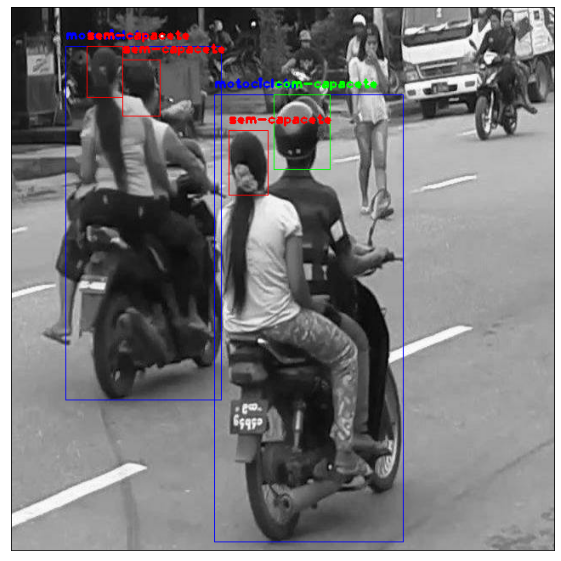

In [123]:
try:
    TRAIN_BATCH = TRAIN_ITERATOR.next()
except:
    TRAIN_ITERATOR = TRAIN.as_numpy_iterator()
    VAL_ITERATOR = VAL.as_numpy_iterator()
    TRAIN_BATCH = TRAIN_ITERATOR.next()

INDEX = 0

img = cv2.cvtColor(TRAIN_BATCH[0][INDEX].copy(), cv2.COLOR_GRAY2RGB)
label = TRAIN_BATCH[1][0][INDEX]
bbox = TRAIN_BATCH[1][1][INDEX]

h,w,c = img.shape

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for boxes,clss in zip(bbox,label):
    if clss != -1:
        cv2.putText(
            img=img,
            text=CLASS[clss][0],
            org=(int(boxes[0]*w),int(boxes[1]*h)-8),
            fontFace=1,
            fontScale=1,
            color=CLASS[clss][1],
            thickness=2
        )
        cv2.rectangle(
            img=img,
            pt1=(int(boxes[0]*w),int(boxes[1]*h)),
            pt2=(int(boxes[2]*w),int(boxes[3]*h)),
            color=CLASS[clss][1],
            thickness=1
        )

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(img, cmap="gray")